In [2]:
import numpy as np
from numpy.linalg import norm

from scipy.fftpack import dct, idct
from scipy.ndimage import correlate1d, gaussian_filter1d

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans, convolve, convolve_fft

%matplotlib inline

np.set_printoptions(linewidth=150)

def load_matrix(fname, encoding='utf8', delimiter=','):
    _data = np.genfromtxt(fname, dtype=np.float64, skip_header=0, delimiter=delimiter, filling_values=None,
                          autostrip=True, encoding=encoding)
    data = _data[1:, 1:]
    times, wavelengths = _data[1:, 0], _data[0, 1:]
    return data, times, wavelengths


def save_mat2csv(fname, matrix, times=None, wls=None, unit='', delimiter=','):
    """Saves matrix with 6 significat digits."""
    times = np.arange(0, matrix.shape[0]) if times is None else times
    wls = np.arange(0, matrix.shape[1]) if wls is None else wls

    mat = np.hstack((times[:, None], matrix))
    buffer = f'unit: {unit} - Time | Wavelength->'
    buffer += delimiter + delimiter.join(f"{num}" for num in wls) + '\n'
    buffer += '\n'.join(delimiter.join(f"{num:.6g}" for num in row) for row in mat)

    with open(fname, 'w', encoding='utf8') as f:
        f.write(buffer)


def plot_data(D, times, wavelengths, symlog=False, title='', t_unit='ps',
              z_unit='$10^3\ \Delta A$', cmap='hot', z_lim=(None, None),
              t_lim=(None, None), w_lim=(None, None), fig_size=(6, 4), dpi=500, filepath=None, transparent=True,
              linthresh=10, linscale=1, D_mul_factor=1e3, y_major_formatter=ScalarFormatter(), x_minor_locator=None):
    """data is individual dataset"""

    plt.rcParams['figure.figsize'] = fig_size
    # plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.23, hspace=0.26)

    # times = data.times
    # wavelengths = data.wavelengths
    # D = data.D * D_mul_factor

    # cut data if necessary

    t_lim = (times[0] if t_lim[0] is None else t_lim[0], times[-1] if t_lim[1] is None else t_lim[1])
    w_lim = (wavelengths[0] if w_lim[0] is None else w_lim[0], wavelengths[-1] if w_lim[1] is None else w_lim[1])

    zmin = np.min(D) if z_lim[0] is None else z_lim[0]
    zmax = np.max(D) if z_lim[1] is None else z_lim[1]

    x, y = np.meshgrid(wavelengths, times)  # needed for pcolormesh to correctly scale the image

    # plot data matrix D

    plt.pcolormesh(x, y, D, cmap=cmap, vmin=zmin, vmax=zmax)

    plt.colorbar(label=z_unit)
    plt.title(title)
    plt.ylabel(f'$\leftarrow$ Time delay / {t_unit}')
    plt.xlabel(r'Wavelength / nm $\rightarrow$')

    plt.ylim(t_lim)
    plt.xlim(w_lim)

    plt.gca().invert_yaxis()
    
    if symlog:
        plt.yscale('symlog', subs=[2, 3, 4, 5, 6, 7, 8, 9], linscale=linscale, linthresh=linthresh)
        yaxis = plt.gca().yaxis
        yaxis.set_minor_locator(MinorSymLogLocator(linthresh))
        
    if y_major_formatter:
        plt.gca().yaxis.set_major_formatter(y_major_formatter)
        
    plt.gca().tick_params(which='major', direction='in')
    plt.gca().tick_params(which='minor', direction='in')
    
    if x_minor_locator:
        plt.gca().xaxis.set_minor_locator(x_minor_locator)

    plt.tight_layout()

    # save to file
    if filepath:
        ext = os.path.splitext(filepath)[1].lower()[1:]
        plt.savefig(fname=filepath, format=ext, transparent=transparent, dpi=dpi)

    plt.show()

In [3]:
# from https://stackoverflow.com/questions/40104377/issiue-with-implementation-of-2d-discrete-cosine-transform-in-python
def dct2(block):
    """
    Computes 2D discrete cosine transform. 
    """
    return dct(dct(block.T, norm='ortho').T, norm='ortho')


def idct2(block):
    """
    Computes 2D inverse discrete cosine transform. 
    """
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

def baseline_2D_arPLS(Y, times, wls, lam0=1e5, lam1=1e2, niter=10, tol: float = 2e-3):
    N = Y.shape[0]
    K = Y.shape[1]
    
    W = np.ones_like(Y)  # weight matrix
    
    # Gamma =     - 2 * np.cos(np.arange(N)[:, None] * np.pi / N) - 2 * np.cos(np.arange(K)[None, :] * np.pi / K)
    
    l0 = 2 * np.sqrt(lam0) * (1 - np.cos(np.arange(N) * np.pi / N))  # eigenvalues of diff matrix for 1st dimension
    l1 = 2 * np.sqrt(lam1) * (1 - np.cos(np.arange(K) * np.pi / K))  # eigenvalues of diff matrix for 2nd dimension

    gamma = 1 / (1 + (l0[:, None] + l1[None, :]) ** 2)

    Z = Y  # intialize the baseline
    D = None
    
    crit = 1
    i = 0
    tdiff, wdiff = times[1] - times[0], wls[1] - wls[0]

    while crit > tol and i < niter:
        Z = idct2(gamma * dct2(W * (Y - Z) + Z))  # calculate the baseline

        D = Y - Z  # data corrected for baseline
        Dn = D[D < 0]  # negative data values
        Dn_matrix = D.copy()
        Dn_matrix[Dn_matrix >= 0] = np.nan
        
        sigma0, sigma1 = 0.3, 5

        kernel = Gaussian2DKernel(sigma1 / wdiff, sigma0 / tdiff)
        Dn_matrix_blured = convolve_fft(Dn_matrix, kernel)
        std_matrix = (Dn_matrix - Dn_matrix_blured) ** 2
        std_matrix_blured = np.sqrt(convolve_fft(std_matrix, kernel))
        std_matrix_blured[std_matrix_blured < 0] = 0
        
        new_W = 1 / (1 + np.exp(2 * (D - (2 * std_matrix_blured - Dn_matrix_blured)) / std_matrix_blured))

#         m = np.mean(Dn)
#         s = np.std(Dn)

#         new_W = 1 / (1 + np.exp(2 * (D - (2 * s - m)) / s))  # update weights with logistic function

        crit = norm(new_W - W) / norm(W)
        W = new_W

        # if (i + 1) % int(np.sqrt(niter)) == 0:
        print(f'Iteration={i + 1}, {crit=:.2g}')
        i += 1

    return Z, D, W, Dn_matrix


#     for i in range(niter):
#         gamma = W + basis
        
#         Z = idct2(dct2(W * Y) / gamma)  # baseline
        
#         D = Y - Z  # data corrected for baseline
#         Df = D.flatten()
        
#         Dfn = Df[Df < 0]

#         m = np.mean(Dfn)
#         s = np.std(Dfn)

#         W = 1 / (1 + np.exp(2 * (D - (2 * s - m)) / s))
        
    return Z, D

#  from 10.1016/j.csda.2009.09.020
def smooth2D(Y, lam0=1e5, lam1=1e2):
    N = Y.shape[0]
    K = Y.shape[1]

    l0 = 1 + lam0 * (-2 + 2 * np.cos(np.arange(N) * np.pi / N)) ** 2
    l1 = 1 + lam1 * (-2 + 2 * np.cos(np.arange(K) * np.pi / K)) ** 2

    basis = l0[:, None] * l1[None, :]

    smooth = idct2(dct2(Y) / basis)
    return smooth


    
def baseline_naive(y, lam=1e4):
    L = len(y)

    diag = np.ones(L - 2)
    D = sparse.spdiags([diag, -2*diag, diag], [0, -1, -2], L, L - 2)

    H = lam * D.dot(D.T)
    
    I = sparse.eye(L)
    z = linalg.spsolve(I + H, y)
    
    return z, y - z

def baseline_AsLS(y, lam=1e4, p=0.1, niter=10):
    L = len(y)

    diag = np.ones(L - 2)
    D = sparse.spdiags([diag, -2*diag, diag], [0, -1, -2], L, L - 2)

    H = lam * D.dot(D.T)
    
    W = sparse.eye(L)
    
    for i in range(niter):
        z = linalg.spsolve(W + H, W * y)
        d = y - z
        
        w = np.where(d > 0, p, 1-p)

        W.setdiag(w)

    return z, d
    
def spectra_model(x):
    coeff = np.array([100, 200, 100, 50])
    mean = np.array([300, 750, 800, 450])

    stdv = np.array([30, 30, 15, 30])

    terms = []
    for ind in range(len(coeff)):
        term = coeff[ind] * np.exp(-((x - mean[ind]) / stdv[ind])**2)
        terms.append(term)

    spectra = sum(terms)

    return spectra

x_vals = np.arange(1, 1001)
spectra_sim = spectra_model(x_vals)

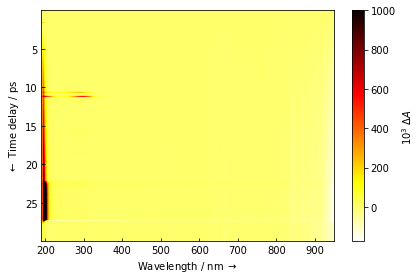

In [4]:
mat, times, wls = load_matrix('UV_DMbr061, after extraction.csv')
plot_data(mat, times, wls, cmap='hot_r', z_lim=(None, 1e3))

In [8]:
# diff = times[1:] - times[:-1]

# np.allclose(diff, diff[0])

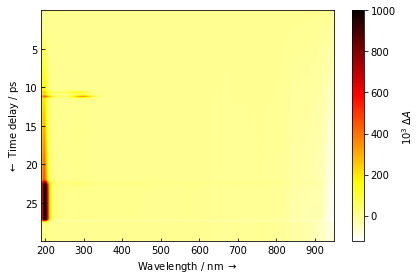

In [5]:
# apply 2D gaussian filter

sigma0, sigma1 = 0.1, 5
tdiff, wdiff = times[1] - times[0], wls[1] - wls[0]

kernel = Gaussian2DKernel(sigma1 / wdiff, sigma0 / tdiff)
filtered = convolve_fft(mat, kernel)

# , interpolate_replace_nans

# filtered = gaussian_filter1d(gaussian_filter1d(mat, sigma0, axis=0), sigma1, axis=1)

plot_data(filtered, times, wls, cmap='hot_r', z_lim=(None, 1e3))

In [6]:
Z, D, W, Dn_matrix = baseline_2D_arPLS(mat, times, wls, 1e6, 0, 10)



Iteration=1, crit=0.15
Iteration=2, crit=0.081
Iteration=3, crit=0.062


C:\Users\dominik\AppData\Local\Temp\ipykernel_4336\179326875.py:51: RuntimeWarning: overflow encountered in exp
  new_W = 1 / (1 + np.exp(2 * (D - (2 * std_matrix_blured - Dn_matrix_blured)) / std_matrix_blured))


Iteration=4, crit=0.055
Iteration=5, crit=0.048
Iteration=6, crit=0.044
Iteration=7, crit=0.041
Iteration=8, crit=0.039
Iteration=9, crit=0.039
Iteration=10, crit=0.038


In [10]:
save_mat2csv('test_mat.csv', D, times, wls)
save_mat2csv('test_mat-baseline.csv', Z, times, wls)

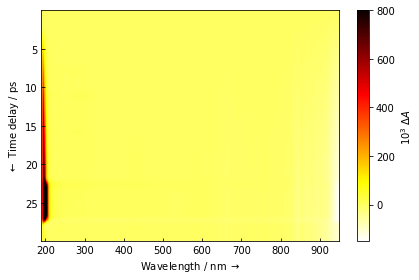

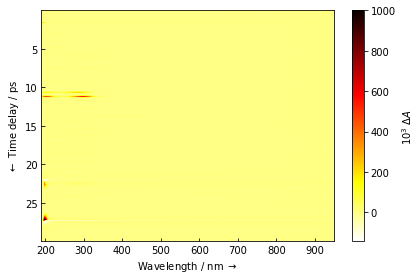

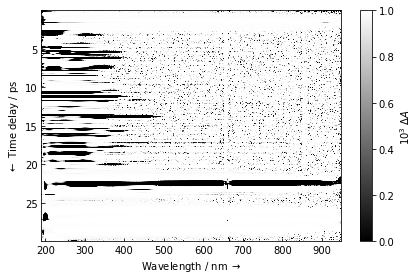

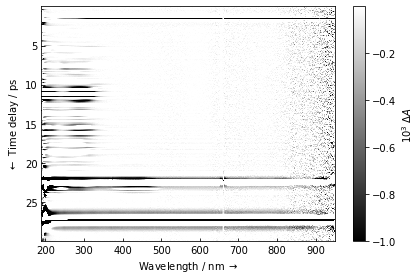

In [8]:
plot_data(Z, times, wls, cmap='hot_r', z_lim=(None, 800))
plot_data(D, times, wls, cmap='hot_r', z_lim=(None, 1e3))
plot_data(W, times, wls, cmap='binary_r', z_lim=(None, None))
plot_data(Dn_matrix, times, wls, cmap='binary_r', z_lim=(-1, np.nanmax(Dn_matrix)))

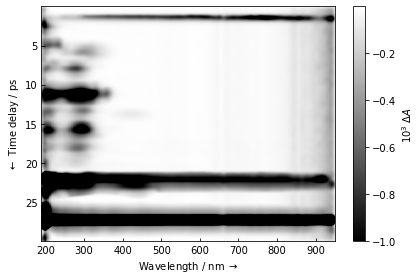

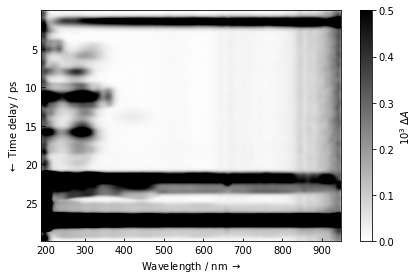

In [79]:
# Apply 2D gaussian blur to negative data

sigma0, sigma1 = 0.3, 5

kernel = Gaussian2DKernel(sigma1 / wdiff, sigma0 / tdiff)
Dn_matrix_blured = convolve_fft(Dn_matrix, kernel)
std_matrix = (Dn_matrix - Dn_matrix_blured) ** 2
std_matrix_blured = np.sqrt(convolve_fft(std_matrix, kernel))
std_matrix_blured[std_matrix_blured < 0] = 0

plot_data(Dn_matrix_blured, times, wls, cmap='binary_r', z_lim=(-1, np.nanmax(Dn_matrix_blured)))
plot_data(std_matrix_blured, times, wls, cmap='binary', z_lim=(0, 0.5))

In [71]:
(std_matrix_blured > 0).sum()

array([[0.03288581, 0.0343448 , 0.03552455, ..., 0.0211991 , 0.01983808, 0.01843348],
       [0.03382054, 0.0353262 , 0.03654503, ..., 0.02173308, 0.02033265, 0.01888823],
       [0.03476497, 0.03631782, 0.03757618, ..., 0.02227353, 0.02083303, 0.01934817],
       ...,
       [0.25718165, 0.27602956, 0.29339232, ..., 0.024287  , 0.0229592 , 0.02154371],
       [0.25336737, 0.27191206, 0.28899241, ..., 0.02395134, 0.02264882, 0.02125897],
       [0.2495122 , 0.26775198, 0.28454854, ..., 0.02361293, 0.02233563, 0.02097136]])

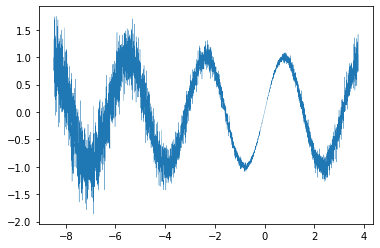

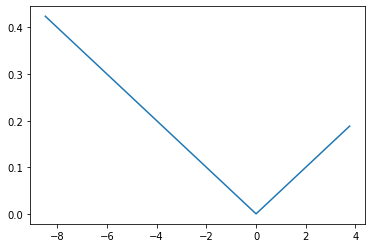

In [153]:
x = np.linspace(-2.7*np.pi, 1.2*np.pi, 5000)
x_abs = np.abs(x) * 0.05

y = np.sin(2*x)

y = np.random.normal(y, x_abs)

plt.plot(x, y, lw=0.3)
plt.show()
plt.plot(x, x_abs)
plt.show()

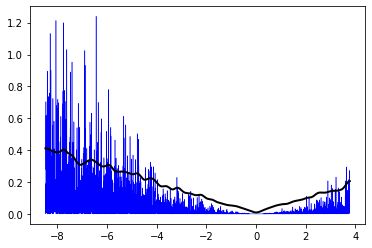

In [160]:
s = 50

y_gb = gaussian_filter1d(y, s, mode='wrap')

diff = (y - y_gb) ** 2
diff_gb = np.sqrt(gaussian_filter1d(diff, s, mode='reflect'))


# plt.plot(x, y, lw=0.3, c='k')
# plt.plot(x, y_gb, lw=2, c='r')
# plt.plot(x, diff, lw=0.3, c='r')

plt.plot(x, diff, lw=0.5, c='b')
plt.plot(x, diff_gb, lw=2, c='k')


plt.show()

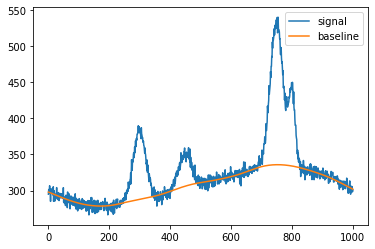

In [7]:
Z, D = baseline_batch_arPLS(spectra_base[:, None], lam=1e6, niter=20)
# Z, D = baseline_arPLS(spectra_base, lam=1e4, niter=50)

plt.plot(x_vals, spectra_base, label='signal')
plt.plot(x_vals, Z, label='baseline')
plt.legend()
plt.show()

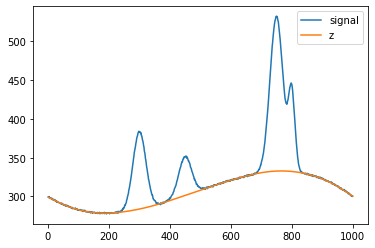

In [14]:
plt.plot(x_vals, spectra_base, label='signal')
plt.plot(x_vals, Z, label='z')
plt.legend()
plt.show()

In [130]:
data = np.genfromtxt('UV_2Z irr, photoproducts2.csv', encoding='utf8', filling_values=0, delimiter=',')

times, wls, matrix = data[1:, 0], data[0, 1:], data[1:, 1:]
data_sel = matrix[500:-700, :]
times_s = times[500:-700]
data_sel.shape

(3300, 760)

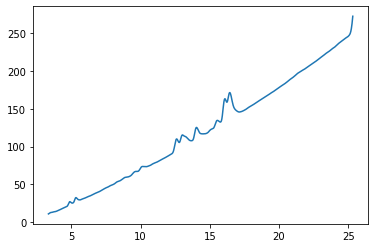

In [16]:
trace = data_sel[:, 10]
plt.plot(times_s, trace)
plt.show()

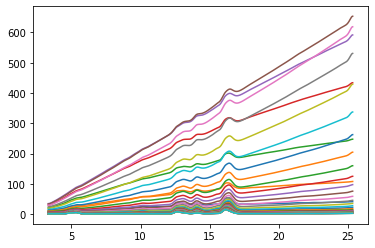

In [163]:
_d = data_sel[:, :50]

N = _d.shape[0]
K = _d.shape[1]
lam0 = 1e5
lam1 = 1

l0 = 1 + lam0 * (-2 + 2 * np.cos(np.arange(N) * np.pi / N)) ** 2
l1 = 1 + lam1 * (-2 + 2 * np.cos(np.arange(K) * np.pi / K)) ** 2

gamma = l0[:, None] * l1[None, :]

smooth = idct2(dct2(_d) / gamma)

plt.plot(times_s, smooth)
plt.show()




# Z, D = baseline_batch_arPLS(_d, lam=1e6, niter=0)
# Z_, D_ = baseline_arPLS_MAT(_d, lam=1e6, niter=0)

# plt.plot(times_s, _d, color='red')
# plt.plot(times_s, Z, color='black')

# plt.show()

# plt.plot(times_s, _d, color='red')
# plt.plot(times_s, Z_, color='black')
# plt.show()


In [85]:
np.allclose(Z, Z_)
Z_

array([[ 5.64217736,  5.65478409],
       [ 5.66738968,  5.67999461],
       [ 5.69259839,  5.70520184],
       ...,
       [62.24675591, 62.29152079],
       [62.33632166, 62.38115509],
       [62.42600484, 62.47086891]])